# Decomposition of Drug Substance Use on Health Dispositions
**AJ Marcus**

2025-02-27

## <font color="teal">Preamble</font>

### <font color="teal">Modules</font>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr
from random import random
from scipy.stats import chi2_contingency, skewnorm
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor
)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    QuantileTransformer
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

### <font color="teal">Functions</font>

In [2]:
def restrata_cat(cpd):
    i = random()
    for idx, x in cpd.items():
        if i > x:
            continue
        else:
            return idx

In [3]:
def restrata_num(mean, std, bounds = None, skew = 0):
    while True:
        x = skewnorm.rvs(a= skew, size= 1)[0]
        x = (x * std) + mean
        if bounds:
            if (x >= bounds[0]) and (x <= bounds[1]):
                return x
            else:
                continue
        else:
            return x

### <font color="teal">Imports</font>

In [4]:
inread = pyreadr.read_r(".data/NSDUH_2023.Rdata")

## <font color="teal">Mining & Preprocessing</font>
Subset features to information pertinent to reseach and analysis hypotheses. Research focuses on physical & mental health quality, drug dependencies, and recent drug uses. Most features utilized are recoded versions of original survey questions, as recoded by survey providers to create consistent, reliable, and viable data points.

Several features are not applicable to minors, which sources the primary reason for excluding them from final analysis. Segmentation analysis by respondent generation will be used to evaluate any necessary grouping or facetting in the report's findings.

In [5]:
subset = [
  # DEMOGRAPHICS
  # Variable                    Name                              Data Type     Preliminary Notes
  # ------------------------------------------------------------------------------------------------------ #
    'AGE3',                   # age                               cat int
    'IRSEX',                  # gender                            cat int
    'SEXIDENT22',             # sexual identity                   cat int
    'IRMARIT',                # marital status                    cat int
    'IREDUHIGHST2',           # education level                   ord int
    'EDUSCHLGO',              # in-school status                  cat int
    'IRWRKSTAT',              # employment status                 cat int
  # 'MILSTAT',                # military status                   cat int       Removed for high nulls
    'ANYHLTI2',               # healthcare status                 cat int
    'GOVTPROG',               # income assistance status          cat int
    'INCOME',                 # annual income                     ord int
    'POVERTY3',               # poverty status                    ord int

  # HEALTH
  # Variable                    Name                              Data Type
  # ------------------------------------------------------------------------------------------------------ #
    'HEALTH',                 # health condition                  ord int
    'BMI2',                   # BMI                               float 9-69
    'KSSLR6MON',              # psych distress score              int 1-24
    'AMIPY',                  # any mental illness -yr            bool

  # DRUG USE
  # Variable                    Name                              Data Type     Risk Factor
  # ------------------------------------------------------------------------------------------------------ #
    'IRPMNICDEP',             # nicotine dependence -yr           bool
    'IRMJFM',                 # pot freq use -mth                 int 1-30      1
    'IRCOCFM',                # cocaine freq use -mth             int 1-30      6
    'IRCRKFM',                # crack freq use -mth               int 1-30      6
    'IRHERFM',                # heroine freq use -mth             int 1-30      7
    'IRHALLUC30N',            # hallucinogens freq use -mth       int 1-30      2
    'IRINHAL30N',             # inhalants freq use -mth           int 1-30      3
    'IRMETHAM30N',            # meth freq use -mth                int 1-30      5
    'IRPNRNM30FQ',            # painmed freq use -mth             int 1-30      8
    'IRTRQNM30FQ',            # tranqs freq use -mth              int 1-30      4
    'IRSTMNM30FQ',            # stims freq use -mth               int 1-30      5
    'IRSEDNM30FQ'             # sedatives freq use -mth           int 1-30      4
]

data = inread['puf2023_102124'][subset]
data = data[data['AGE3'] > 3]

Relabel features for readability.

In [6]:
renames = {
            'AGE3': 'generation',
        'ANYHLTI2': 'health_insurance_flag',
            'BMI2': 'bmi',
       'EDUSCHLGO': 'education_flag',
        'GOVTPROG': 'income_assistance_flag',
          'HEALTH': 'health_level',
         'IRCOCFM': 'cocaine_use',
          'INCOME': 'annual_income',
         'IRCRKFM': 'crack_use',
    'IREDUHIGHST2': 'education_level',
     'IRHALLUC30N': 'hallucinogen_use',
         'IRHERFM': 'heroine_use',
      'IRINHAL30N': 'inhalant_use',
         'IRMARIT': 'marital',
     'IRMETHAM30N': 'amphetamine_use',
          'IRMJFM': 'marajuana_use',
      'IRPMNICDEP': 'nicotine_dependence_flag',
     'IRPNRNM30FQ': 'opioid_use',
     'IRSEDNM30FQ': 'sedative_use',
           'IRSEX': 'gender',
     'IRSTMNM30FQ': 'stimulant_use',
       'IRWRKSTAT': 'employment',
     'IRTRQNM30FQ': 'tranquilizer_use',
       'KSSLR6MON': 'psychological_distress',
#        'MILSTAT': 'military_service',
        'POVERTY3': 'poverty_level',
      'SEXIDENT22': 'sexuality',
           'AMIPY': 'mental_illness_flag'
}

data = data.rename(columns= renames)

### <font color="teal">Recoding</font>
Recoding variables from system codes to readable elements. Some overwriting recoding has been done to retain usability of some features, and is annotated accordingly.

**Recode Edits:**
<ol>
    <li>Annual Income was grouped into survey ranges; groups are being populated to maintain uniform distributions within each band to allow smoother normalization in model preprocessing efforts.</li>
    <li>Slight deviations of 0-3 years were made when switching age buckets to generations and ages were grouped into the generation which majority-mapped to the applicable range.</li>
</ol>

In [7]:
# recoding
recodes = {
    'education_flag': {
         1: 'True',
         2: 'False',
        11: 'True'
    },
    'education_level': {        # effective US grade level
         1: 5,
         2: 6,
         3: 7,
         4: 8,
         5: 9,
         6: 10,
         7: 11,
         8: 12,
         9: 12,
        10: 13,
        11: 14
    },
    'employment': {
         1: 'Full Employment',
         2: 'Partial Employment',
         3: 'Unemployed',
         4: pd.NA,
        99: pd.NA
    },
    'gender': {
        1: 'Male',
        2: 'Female'
    },
    'generation': {             # see recode note 2
         1: 'A',
         2: 'Z',
         3: 'Zillennial',
         4: 'Zillennial',
         5: 'Zillennial',
         6: 'Zillennial',
         7: 'Millennial',
         8: 'Millennial',
         9: 'Xennial',
        10: 'X',
        11: 'Baby Boomer'
    },
    'health_insurance_flag': {
        1: 'True',
        2: 'False'
    },
    'health_level': {
        1: 5,
        2: 4,
        3: 3,
        4: 2,
        5: 1
    },
    'income_assistance_flag': {
        1: 'True',
        2: 'False'
    },
    'marital': {
        None: 'Single',
           1: 'Married',
           2: 'Widowed',
           3: 'Divorced',
           4: 'Single'
        
    },
    'nicotine_dependence_flag': {
        0: 'False',
        1: 'True'
    },
    'poverty_level': {
        1: 'Below',
        2: 'Baseline',
        3: 'Above'
    },
    'sexuality': {
        1: 'Heterosexual',
        2: 'Homosexual',
        3: 'Bisexual'
    },
    'mental_illness_flag': {
        0: 'False',
        1: 'True'
    }
}

for c in recodes:
    mapper = recodes[c]
    data[c] = data[c].map(mapper)

`Drug Use` fields have 90-series codes referring to insufficient, bad, or non-applicable data. Features with such values are recoded to no use for conservative utility of the fields and biases against the hypothesis to increate the threshold of positive analysis results.

In [8]:
reranges = [
    'amphetamine_use',
    'cocaine_use',
    'crack_use',
    'hallucinogen_use',
    'heroine_use',
    'inhalant_use',
    'marajuana_use',
    'opioid_use',
    'sedative_use',
    'stimulant_use',
    'tranquilizer_use'
]

for c in reranges:
    data[c] = data[c].apply(lambda x: 0 if x > 30 else x)

Clean datatypes

In [9]:
data['education_level'] = data['education_level'].astype(float)
data['annual_income'] = data['annual_income'].astype(float)

### <font color="teal">Missing at Random Analysis</font>
Several features show missing data. Missing at Random (MAR) analyses are done to reduce inter-dependency analysis and feature size for the model selection stages. Dependency is tested via Chi-Squared tests at the &alpha; = 0.05 level.

In [10]:
data.isnull().sum()

generation                      0
gender                          0
sexuality                    4956
marital                         0
education_level                 0
education_flag               1688
employment                  13444
health_insurance_flag        1740
income_assistance_flag          0
annual_income                   0
poverty_level                  11
health_level                   14
bmi                          1964
psychological_distress          0
mental_illness_flag             0
nicotine_dependence_flag        0
marajuana_use                   0
cocaine_use                     0
crack_use                       0
heroine_use                     0
hallucinogen_use                0
inhalant_use                    0
amphetamine_use                 0
opioid_use                      0
tranquilizer_use                0
stimulant_use                   0
sedative_use                    0
dtype: int64

In [11]:
data_missing = data.isna()
colset = []

for i in range(len(data_missing.columns)):
    for j in range(i, len(data_missing.columns)):
        combo = sorted([data_missing.columns[i], data_missing.columns[j]])
        if combo[0] == combo[1]:
            continue
        if combo not in colset:
            colset.append(combo)

missing_tests = []
for a, b in colset:
    contingency = pd.crosstab(data_missing[a], data_missing[b])
    chi2, p, dof, expected = chi2_contingency(contingency)
    if p < .05:
        result = 'Dependent'
    else:
        result = 'Independent'
    if dof > 0:
        missing_tests.append(
            (a, b, round(p, 4), result)
    )
        
cross_missing = pd.DataFrame(missing_tests, columns= ['feature_a', 'feature_b', 'p_value', 'dependency'])
cross_missing = cross_missing[cross_missing['dependency'] == 'Dependent']
cross_missing = cross_missing.sort_values(['p_value', 'feature_a', 'feature_b']).reset_index(drop= True)
cross_missing

,feature_a,feature_b,p_value,dependency
0,bmi,education_flag,0.0000,Dependent
1,bmi,employment,0.0000,Dependent
2,bmi,health_insurance_flag,0.0000,Dependent
3,bmi,health_level,0.0000,Dependent
4,bmi,sexuality,0.0000,Dependent
5,education_flag,employment,0.0000,Dependent
6,education_flag,health_insurance_flag,0.0000,Dependent
7,education_flag,health_level,0.0000,Dependent
8,education_flag,sexuality,0.0000,Dependent
9,employment,sexuality,0.0000,Dependent


We can see the dependency tests show 7 features dependent on each other in some combination. Preliminary EDA revealed other features that were revoked in report refinement (i.e. `military_service`) and others have a real world relationship we expect some dependency on (i.e. `employment` and `health_insurance_flag`). Results indicate the majority of these nulls can be restratified with appropriate filling scalers and transformations, while the `employment` and `health_insurance_flag` pair may not be applicable due to them not assuredly be MAR given the confidence bounds of the test.

### <font color="teal">Null Cleanup & Restrata</font>
This is done only on previously-identified applicable fields (or on fields that did not result in the MAR analysis) that can be reasonably expected to not impact clustering or predictive analysis and is not done on fields with high null content.

In [12]:
restratas_cat = [
    'education_flag',
    'health_insurance_flag',
    'health_level',
    'psychological_distress',
    'sexuality'
]

for c in restratas_cat:
    a = data[c].value_counts(normalize= True)
    cpd = a.sort_index().cumsum()
    data[c] = data[c].apply(lambda x: x if pd.notna(x) else restrata_cat(cpd))

In [13]:
restratas_num = [
    'bmi'
]
        
for c in restratas_num:
    a, b = data[c].min(), data[c].max()
    m, d, s = data[c].mean(), data[c].std(), data[c].skew()
    data[c] = data[c].apply(lambda x: x if pd.notna(x) else restrata_num(m, d, bounds= [a, b], skew= s))

All remaining nulls are dropped to create the final cleaned dataset for modeling purposes.

In [14]:
data_clean = data.dropna()
data_clean.shape

(31683, 27)

### <font color="teal">Distribution Analysis</font>

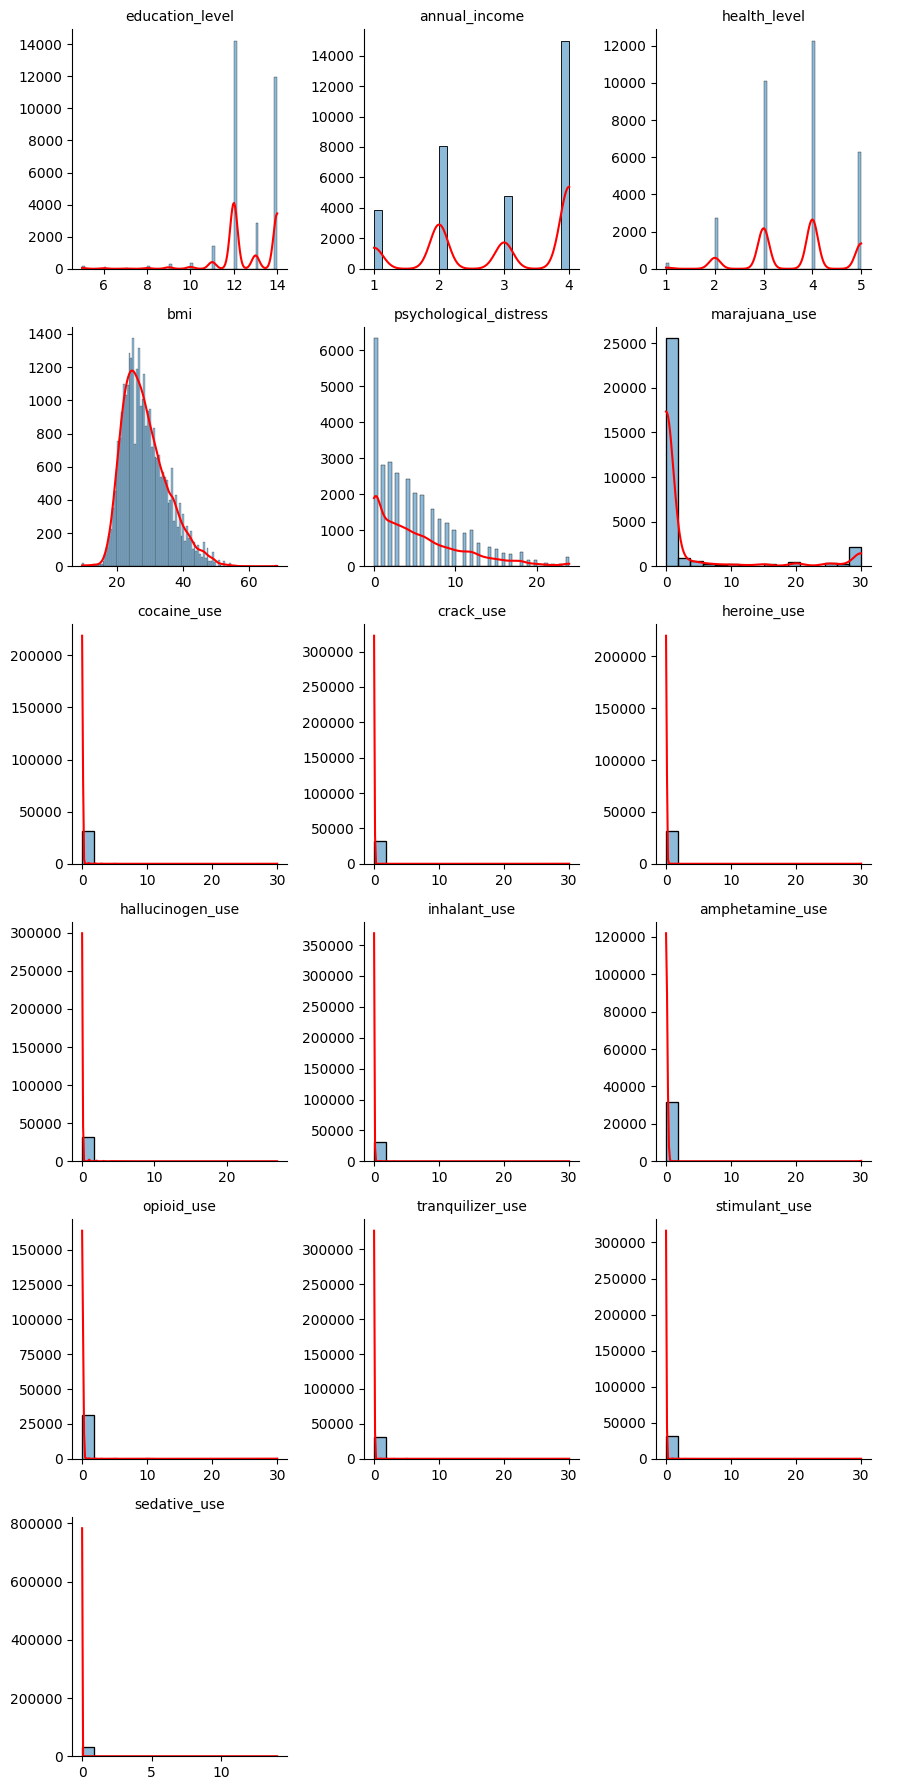

In [15]:
cols_nums = data_clean.select_dtypes(include= 'number').columns.tolist()
df_melt = data_clean[cols_nums].melt(
    var_name= 'col',
    value_name='val'
)

g = sns.FacetGrid(
    df_melt,
    col= 'col',
    col_wrap= 3,
    sharex= False,
    sharey= False
)
g.map(
    sns.histplot, 
    'val', 
    kde= True
).add_legend()

for ax in g.axes.flat:
    for line in ax.lines:
        line.set_color('red')


g.set_axis_labels('', '')
g.set_titles("{col_name}")
g.tight_layout()
plt.show()

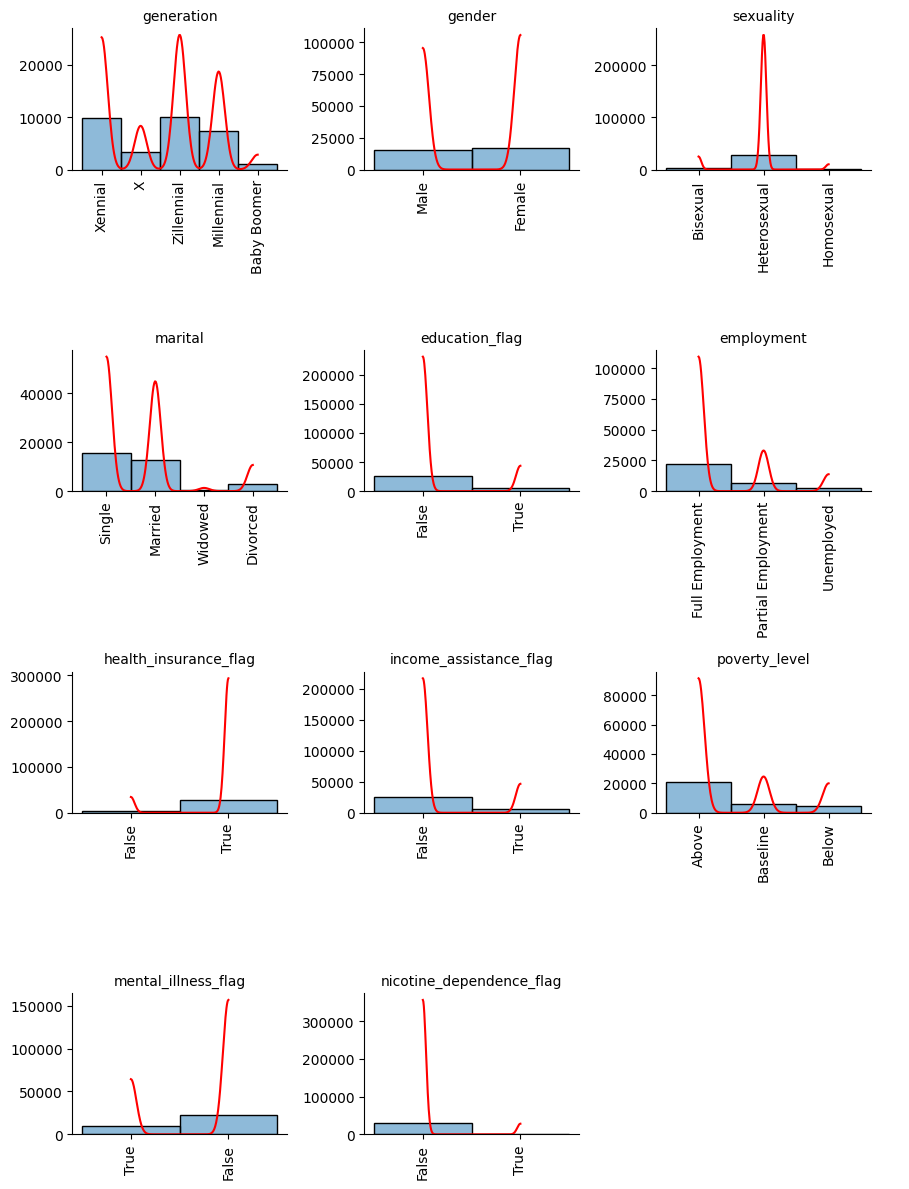

In [16]:
cols_cats = data_clean.select_dtypes(exclude= 'number').columns.tolist()
df_melt = data_clean[cols_cats].melt(
    var_name= 'col',
    value_name='val'
)

g = sns.FacetGrid(
    df_melt,
    col='col',
    col_wrap= 3,
    sharex= False,
    sharey= False
)
g.map(
    sns.histplot, 
    'val', 
    kde= True
).add_legend()

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    for line in ax.lines:
        line.set_color('red')

# Adjust layout
g.set_axis_labels('', '')
g.set_titles("{col_name}")
g.tight_layout()
plt.show()

### <font color="teal">Scaling and Preprocessing</font>
Distribution analysis shows the majority of features are not applicable to standard transformations for modeling. Drug use fields were chosen to apply `PowerTransformation` in order to handle the heavily skewed data creating outlier and distortion. Each modeling section creates its transformations applicable to the model subsets.

Performancce was evaluated in some model applications on the transformations used in liew of `PowerTransformation` with negligible-to-marginally negative results over the selected distribution. Those results are not shown here for concision. 

In [17]:
cols_minmax = [
   'bmi'
]

cols_onehot = [
    'education_flag',
    'employment',
    'gender',
    'health_insurance_flag',
    'income_assistance_flag',
    'marital',
    'mental_illness_flag',
    'nicotine_dependence_flag',
    'poverty_level',
    'sexuality'
]

cols_ordinal = [
    'generation'
]

cols_poweryeo = [
    'amphetamine_use',
    'cocaine_use',
    'crack_use'	,
    'hallucinogen_use',
    'heroine_use',
    'inhalant_use',
    'marajuana_use',
    'opioid_use',
    'psychological_distress',
    'sedative_use',
    'stimulant_use',
    'tranquilizer_use'
]

cols_quantnorm = [
    'education_level',
    'health_level'
]

cols_quantuni = [
   'annual_income'
]

## <font color="teal">Principal Component Analysis</font>
The goal of this PCA is to try and identify key features that heavily-classify the data. Outputs from the PCA will be used to see if the highest-classifying features can be used to accurately and simply classify the data in other models.

In [18]:
# preprocess transformations
tf_minmax = MinMaxScaler()
tf_onehot = OneHotEncoder()
tf_ordinal = OrdinalEncoder()
tf_poweryeo = PowerTransformer(method= 'yeo-johnson')
tf_quantnorm = QuantileTransformer(output_distribution= 'normal')
tf_quantuni = QuantileTransformer(output_distribution= 'uniform')

preprocessor = ColumnTransformer(
    transformers=[
        ('tf1', tf_minmax, cols_minmax),
        ('tf2', tf_onehot, cols_onehot),
        ('tf3', tf_ordinal, cols_ordinal),
        ('tf5', tf_poweryeo, cols_poweryeo),
        ('tf6', tf_quantnorm, cols_quantnorm),
        ('tf7', tf_quantuni, cols_quantuni)
    ]
)

data_processed = preprocessor.fit_transform(data_clean)

# explained variances
evr = []
for n in range(3, len(preprocessor.get_feature_names_out())):
    model_pca = PCA(n_components= n)
    pca_fit = model_pca.fit(data_processed)
    evr.append((n, sum(model_pca.explained_variance_ratio_)))

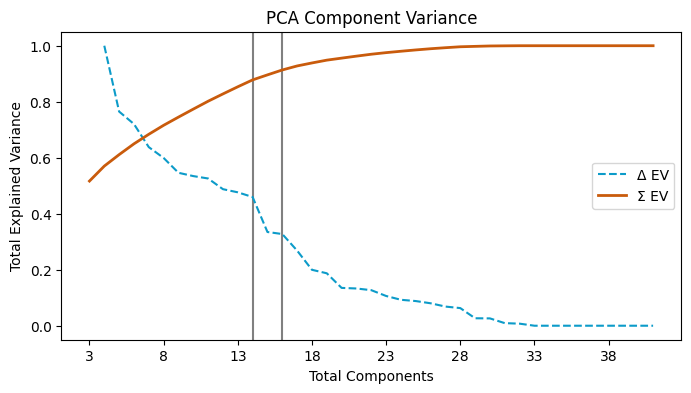

In [19]:
z = []
for i, (x, y) in enumerate(evr):
    if i == len(evr) - 1:
        continue
    z.append(evr[i + 1][1] - y)

z = z / max(z)
x, y = zip(*evr)

plt.figure(figsize= (8, 4))
plt.axvline(x= 14, color= 'gray')
plt.axvline(x= 16, color= 'gray')
plt.plot(
    x[1:], z,
    linestyle= '--',
    color= '#0c9bc9',
    label= 'Δ EV'
)
plt.plot(
    x, y,
    linestyle= '-',
    color= '#c95b0c',
    linewidth= 2,
    label= 'Σ EV'
)
plt.xticks(np.arange(3, max(x) + 1, 5))
plt.xlabel('Total Components')
plt.ylabel('Total Explained Variance')
plt.title('PCA Component Variance')
plt.legend(loc= 'center right') 
plt.show()

In [20]:
oc = [14, 16]
for i in oc:
    model_pca = PCA(n_components= i)
    pca_fit = model_pca.fit(data_processed)
    oev = sum(model_pca.explained_variance_ratio_)
    print(f"Optimal Explained Variance of {oev:.4f} with {i} Components")

Optimal Explained Variance of 0.8780 with 14 Components
Optimal Explained Variance of 0.9134 with 16 Components


In [21]:
pca_feature_names = preprocessor.get_feature_names_out()
pca_top_components = model_pca.components_[:max(oc)]
pca_components = pd.DataFrame()

for i, component in enumerate(pca_top_components):
    sorted_feature_idx = np.argsort(np.abs(component))[::-1]
    sorted_feature_names = preprocessor.get_feature_names_out()[sorted_feature_idx]
    sorted_loadings = component[sorted_feature_idx]

    row = dict(zip(sorted_feature_names, sorted_loadings))
    pca_components = pd.concat(
        [pca_components, pd.DataFrame([row])],
        ignore_index= True
    )

### <font color="teal">Borda Influence Scores</font>
Results showed 16 component vectors the optimal total variance coverage. To determine which features have the highest influence over the components, we will use weighted borda summations where each subsequent component vector has a linearly devalued weight and the borda score values of each vector are calculated. The lower the weighted score, the more value it contributed to the explained variance within each component vector.

In [22]:
pca_compranks = pca_components.T.abs().rank(method= 'dense', ascending= False)
for i in pca_compranks.columns:
    pca_compranks[i] = pca_compranks[i] * (16 - i)
borda_scores = round(pca_compranks.sum(axis= 1) / 16, 1)
borda_scores.sort_values(ascending= True)[:10]

tf5__marajuana_use              58.3
tf3__generation                 66.1
tf5__psychological_distress     68.8
tf5__amphetamine_use            79.1
tf5__cocaine_use                83.1
tf5__opioid_use                 85.3
tf5__heroine_use                89.9
tf5__tranquilizer_use          100.8
tf5__crack_use                 101.3
tf5__hallucinogen_use          103.1
dtype: float64

### <font color="teal">Multicolinearity</font>
The downside is a potential concern of multicolinearity or intra-dependence, which will be evaluated next utilizing a variance inflation factor analysis.

In [23]:
mc_cols = [
    'psychological_distress',
    'marajuana_use',
    'hallucinogen_use',
    'cocaine_use',
    'opioid_use',
    'stimulant_use',
    'inhalant_use',
    'heroine_use',
    'tranquilizer_use',
    'amphetamine_use'
]
correlation_matrix = data[mc_cols].corr()

vif_data = pd.DataFrame()
vif_data['feature_name'] = data[mc_cols].columns
vif_data['vif_score'] = [variance_inflation_factor(data[mc_cols].values, i) for i in range(data[mc_cols].shape[1])]

print("\nVariance Inflation Factor (VIF):\n", vif_data)


Variance Inflation Factor (VIF):
              feature_name  vif_score
0  psychological_distress   1.180237
1           marajuana_use   1.182923
2        hallucinogen_use   1.028839
3             cocaine_use   1.094480
4              opioid_use   1.071641
5           stimulant_use   1.020335
6            inhalant_use   1.014413
7             heroine_use   1.137491
8        tranquilizer_use   1.067827
9         amphetamine_use   1.074707


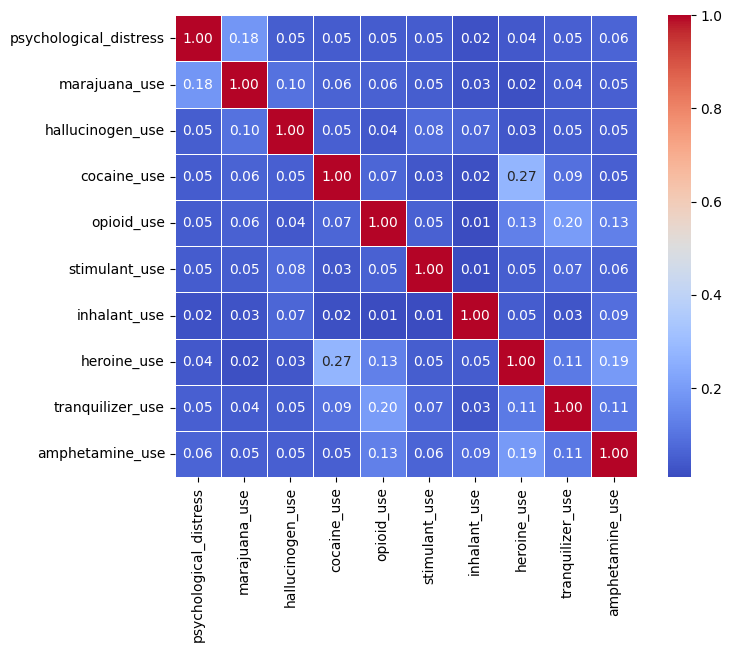

In [24]:
plt.figure(figsize= (8, 6))
sns.heatmap(
    correlation_matrix,
    annot= True,
    cmap= 'coolwarm',
    fmt= '.2f',
    linewidths= 0.5,
    square= True
)
plt.show()

Fortunately all features showed negligible correlation rates and low VIF scores, meaning all features are independently and collectively viable influencers to the analysis.

## <font color="teal">Prediction Models: **Health Level**</font>
Challenge: `Health Level` is a respondent-percieved status on their overall health disposition, with 1-5 representing bad to great. Can this be directly imputed from given data? Can it be imputed specifically from drug use and addiction statuses?

### <font color="teal">Full Featureset</font>

In [25]:
# preprocess transformers
tf_minmax = MinMaxScaler()
tf_onehot = OneHotEncoder()
tf_ordinal = OrdinalEncoder()
tf_poweryeo = PowerTransformer(method= 'yeo-johnson')
tf_quantnorm = QuantileTransformer(output_distribution= 'normal')
tf_quantuni = QuantileTransformer(output_distribution= 'uniform')

# pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('tf1', tf_minmax, cols_minmax),
        ('tf2', tf_onehot, cols_onehot),
        ('tf3', tf_ordinal, cols_ordinal),
        ('tf5', tf_poweryeo, cols_poweryeo),
        ('tf6', tf_quantnorm, [x for x in cols_quantnorm if x != 'health_level']),
        ('tf7', tf_quantuni, cols_quantuni)
    ]
)

# datasplit
X_train, X_test, y_train, y_test = train_test_split(
    data_clean.drop(columns= 'health_level'),
    data_clean['health_level'],
    train_size= .2,
    random_state= 13
)

# apply fit transformations
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

#### <font color="teal">Logistic Classifier</font>

In [26]:
model = LogisticRegression(random_state= 13, max_iter= 1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

acc = accuracy_score(y_train, y_pred_train)

print(f"Overall Train Accuracy: {acc:.4f}")

acc = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Overall Test Accuracy: {acc:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Overall Train Accuracy: 0.4598
Overall Test Accuracy: 0.4470
Mean Absolute Error: 0.6381


#### <font color="teal">Logistic Forward Selection</font>

In [27]:
model = LogisticRegression(max_iter= 500, random_state= 13)
sfs = SequentialFeatureSelector(
    model,
    n_features_to_select= 'auto',
    direction= 'forward',
    cv= 5
)
sfs.fit(X_train_scaled, y_train)

selected_features = sfs.get_support(indices= True)
X_train_selected = X_train_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
y_pred_train = model.predict(X_train_selected)

acc = accuracy_score(y_train, y_pred_train)

print(f"Overall Train Accuracy: {acc:.4f}")

acc = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Overall Test Accuracy: {acc:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Overall Train Accuracy: 0.4601
Overall Test Accuracy: 0.4473
Mean Absolute Error: 0.6366

Classification Report:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       229
         2.0       0.25      0.01      0.01      2175
         3.0       0.44      0.45      0.45      8066
         4.0       0.45      0.73      0.56      9793
         5.0       0.45      0.11      0.17      5084

    accuracy                           0.45     25347
   macro avg       0.32      0.26      0.24     25347
weighted avg       0.43      0.45      0.39     25347



In [28]:
preprocessor.get_feature_names_out()[selected_features]

array(['tf1__bmi', 'tf2__education_flag_False',
       'tf2__education_flag_True', 'tf2__income_assistance_flag_False',
       'tf2__income_assistance_flag_True', 'tf2__marital_Divorced',
       'tf2__marital_Widowed', 'tf2__nicotine_dependence_flag_False',
       'tf2__nicotine_dependence_flag_True', 'tf2__poverty_level_Below',
       'tf5__amphetamine_use', 'tf5__cocaine_use', 'tf5__crack_use',
       'tf5__heroine_use', 'tf5__inhalant_use', 'tf5__marajuana_use',
       'tf5__psychological_distress', 'tf5__sedative_use',
       'tf5__stimulant_use', 'tf6__education_level'], dtype=object)

#### <font color="teal">Random Forest</font>

In [29]:
model = RandomForestRegressor(n_estimators= 50, random_state= 13)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

r2 = r2_score(y_train, y_pred_train)

print(f"Train R² Score: {r2:.4f}")

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Train R² Score: 0.8696
Test R² Score: 0.1192
Mean Absolute Error: 0.6917


#### <font color="teal">Gradient Booster</font>

In [30]:
model = GradientBoostingRegressor(n_estimators= 50, learning_rate=0.1, max_depth=3, random_state= 13)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_train, y_pred_train)
print(f"Train R² Score: {r2:.4f}")

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Test R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

Train R² Score: 0.8696
Test R² Score: 0.1892
Mean Squared Error: 0.6837


### <font color="teal">Drug Use Sub-Featureset</font>

In [31]:
drug_subset = [
    'mental_illness_flag',
    'nicotine_dependence_flag',
    'amphetamine_use',
    'cocaine_use',
    'crack_use'	,
    'hallucinogen_use',
    'heroine_use',
    'inhalant_use',
    'marajuana_use',
    'opioid_use',
    'sedative_use',
    'stimulant_use',
    'tranquilizer_use',
    'health_level'
]

In [32]:
data_clean_subset1 = data_clean[drug_subset]
tf_onehot = OneHotEncoder(drop= 'first')
tf_poweryeo = PowerTransformer(method= 'yeo-johnson')

preprocessor = ColumnTransformer(
    transformers=[
        ('tf2', tf_onehot, [
            'mental_illness_flag',
            'nicotine_dependence_flag'
        ]),
        ('tf5', tf_poweryeo, [
            'amphetamine_use',
            'cocaine_use',
            'crack_use'	,
            'hallucinogen_use',
            'heroine_use',
            'inhalant_use',
            'marajuana_use',
            'opioid_use',
            'sedative_use',
            'stimulant_use',
            'tranquilizer_use'
        ])
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    data_clean_subset1.drop(columns= 'health_level'),
    data_clean_subset1['health_level'],
    train_size= .2,
    random_state= 13
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

#### <font color="teal">Logistic Classifier</font>

In [33]:
model = LogisticRegression(random_state= 13, max_iter= 1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

acc = accuracy_score(y_train, y_pred_train)

print(f"Overall Train Accuracy: {acc:.4f}")

acc = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Overall Test Accuracy: {acc:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Overall Train Accuracy: 0.4216
Overall Test Accuracy: 0.4086
Mean Absolute Error: 0.6752


### <font color="teal">Generation Predictor</font>

In [34]:
generation_subset = [
    'generation',
    'mental_illness_flag',
    'nicotine_dependence_flag',
    'amphetamine_use',
    'cocaine_use',
    'crack_use'	,
    'hallucinogen_use',
    'heroine_use',
    'inhalant_use',
    'marajuana_use',
    'opioid_use',
    'sedative_use',
    'stimulant_use',
    'tranquilizer_use'
]

#### <font color="teal">Random Forest</font>

In [35]:
data_clean_subset2 = data_clean[generation_subset].copy()
tf_poweryeo = PowerTransformer(method= 'yeo-johnson')

label_encoder = LabelEncoder()
data_clean_subset2['generation'] = \
    label_encoder.fit_transform(data_clean_subset2['generation'])
data_clean_subset2['mental_illness_flag'] = \
    data_clean_subset2['mental_illness_flag'].map({'True': 1, 'False': 0})
data_clean_subset2['nicotine_dependence_flag'] = \
    data_clean_subset2['nicotine_dependence_flag'].map({'True': 1, 'False': 0})
data_clean_subset2[[
    'amphetamine_use',
    'cocaine_use',
    'crack_use'	,
    'hallucinogen_use',
    'heroine_use',
    'inhalant_use',
    'marajuana_use',
    'opioid_use',
    'sedative_use',
    'stimulant_use',
    'tranquilizer_use'
]] = tf_poweryeo.fit_transform(data_clean_subset2[[
    'amphetamine_use',
    'cocaine_use',
    'crack_use'	,
    'hallucinogen_use',
    'heroine_use',
    'inhalant_use',
    'marajuana_use',
    'opioid_use',
    'sedative_use',
    'stimulant_use',
    'tranquilizer_use'
]])

X = data_clean_subset2.drop(columns=['generation'])
y = data_clean_subset2['generation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 13)
model = RandomForestClassifier(n_estimators= 50, random_state= 13)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2 = accuracy_score(y_train, y_pred_train)
print(f"Overall Train Accuracy: {r2:.4f}")

r2 = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Overall Test Accuracy: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Overall Train Accuracy: 0.3743
Overall Test Accuracy: 0.3618
Mean Absolute Error: 1.0642


#### <font color="teal">Support Vector Machines</font>

In [36]:
model = SVC(kernel='rbf', C= 1.0, gamma= 'scale', random_state= 13)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

acc = accuracy_score(y_train, y_pred_train)
print(f"Overall Train Accuracy: {acc:.4f}")

acc = accuracy_score(y_test, y_pred)
mae = mean_absolute_error (y_test, y_pred)

cr = classification_report(y_test, y_pred, target_names= label_encoder.classes_, zero_division= 1)
print(f"Overall Test Accuracy: {acc:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"\nClassification Report:\n{cr}")

Overall Train Accuracy: 0.3649
Overall Test Accuracy: 0.3617
Mean Absolute Error: 1.0704

Classification Report:
              precision    recall  f1-score   support

 Baby Boomer       1.00      0.00      0.00       208
  Millennial       0.22      0.02      0.03      1437
           X       0.00      0.00      0.00       648
     Xennial       0.35      0.67      0.46      2024
  Zillennial       0.39      0.45      0.42      2020

    accuracy                           0.36      6337
   macro avg       0.39      0.23      0.18      6337
weighted avg       0.32      0.36      0.29      6337



### <font color="teal">Conclusion</font>
PCA was successfull in reducing the dimensions of our data, with explained variances in excess of 90% distribution. Component vectors showed the drug usage features have the highest consistent influence. This is an expected and positive result because it shows consistent viability of the drug usage data in classifying survey respondents. Integrity validations will be needed to ensure there is no dependency factor within these features because the usage of them is not assuredly mutually exclusive. Multicolinearity analysis later showd these dependencies were not an issue, supporting the integrity of the PCA results.

Overall, even though PCA was successfull, analysis around the drug use data yielded unusable predictive models. Health Levels were modeled with subpar results and accuracies ranging between sub-random chance (20%) and 50%. Efforts to identify generational classifications were even less successfull.

The mixed results of this report show poor modeling efficacy on the entire collection of respondents. Post-analysis research on other peer journals with the survey data show different methodologies on focused demographic subsets had more informative results. Most analysis focused on adolescents, gender, and the rise in opioid use as time-series analysis over several survey report years;<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite-1) <a name="cite_ref-1"></a>[<sup>[2]</sup>](#cite-2) other reports were able to expand and compare the survey responses to comparable clinical analysis.<a name="cite_ref-1"></a>[<sup>[3]</sup>](#cite-3)

<a name="cite_note-1"></a>[^](#cite-1)1. <u>National Estimates of Marijuana Use and Related Indicators</u> http://dx.doi.org/10.15585/mmwr.ss6511a1

<a name="cite_note-1"></a>[^](#cite-2)2. <u>Gender and prescription opioids: Findings from the National Survey on Drug Use and Health</u> https://doi.org/10.1016/j.addbeh.2010.06.018

<a name="cite_note-1"></a>[^](#cite-3)3. <u>A clinical validation of the National Survey on Drug Use and Health Assessment of Substance Use Disorders</u> https://doi.org/10.1016/j.addbeh.2007.12.007